# Colon Cancer Cell Classification (Project 1)
We will be using a modified version of the “CRCHistoPhenotypes" dataset for this task. The dataset consists
of 27x27 RGB images of colon cells from 99 different patients and we are expected to use the dataset to
perform two tasks:
- Classify images according to whether given cell image represents a cancerous cell or not (`isCancerous`).
- Classify images according to cell-type, such as: fibroblast, inflammatory, epithelial or others.

Therefore Our Machine Learning Tasks are follwing: 
- Task 1: Classify images, whether given cell image represents a cancerous cell or not (`isCancerous`). 
- Taks 2: Classify images according to cell-type, such as: fibroblast, inflammatory, epithelial or others.  

# Importing Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Unzip image file data

In [2]:
# unzipping file
!gdown https://drive.google.com/uc?id=1Ypdy3Tzl8TTudbbuJqWfmnhcblTXG-y1 -O data.zip
!unzip -qq data.zip

Downloading...
From: https://drive.google.com/uc?id=1Ypdy3Tzl8TTudbbuJqWfmnhcblTXG-y1
To: /content/data.zip
40.7MB [00:00, 53.2MB/s]


#### Setting up directories and libraries 

In [4]:
import os
import glob
import shutil
from pathlib import Path

import pandas as pd
import seaborn as sns
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation,
    Dense, Dropout, MaxPooling2D, Flatten,
    ZeroPadding2D, Input, GlobalAveragePooling2D,GlobalMaxPooling2D,
    AveragePooling2D, Add)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score, classification_report 
from matplotlib import pyplot as plt

%matplotlib inline


In [5]:
# import numpy as np
# from matplotlib import pyplot as plt
# import pandas as pd

#data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data = pd.read_csv('/content/data_labels_mainData.csv')
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


# Performance Metrics
The given problem is "Solved". In this case, the performance of the model highly depends on the qaulity of training dataset [1]. The current State-of-art DL models trained on an extensive training set containing more than 15,000 patients of various cancer types, obtained across 45 countries achieved an excellent performance of AUC greater than 0.98 for cell histology task [1]. Besides that, researchers using Deep CNN so far achieved 94.5% accuracy for cell detection and 82%, 58% , 62%, 92% {Class - normal, HP, TA_LG, CA} for cell type classifcation [2]. Another research has stated that, they have achieved F1-Score of 0.784 with multiclass AUC score 0.917 for cell type classification [3].

Therefore,  we have choosen the following performance metrics

Task 1: 
- Performance Metrics: F1-Score
- Target Performance:  F1-Score of 0.91 

Task 2: 
- Performance Metrics: F1-Score
- Target Performance:  F1-Score of 0.81


For both tasks we will be observing accuracy score as well.

# Exploratory Data Analysis

Trends in the .csv file are explored and visualised to determine effective approaches for the model as well as what general predictions the model may make.



In [6]:
# Checking if any NaN values are in the dataset
data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

#### **Data Balance and Imbalance**

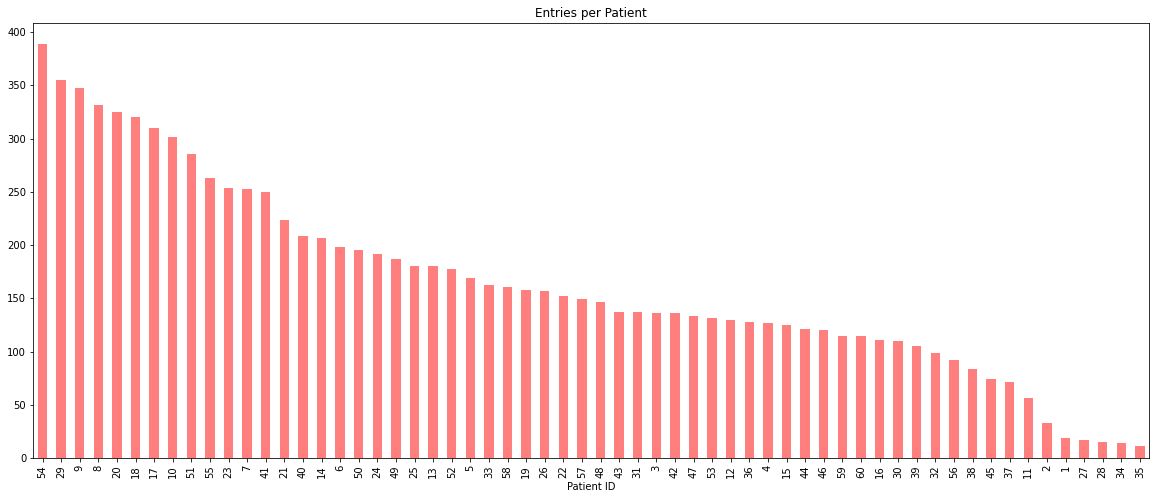

In [7]:
# Plot the number of entries within the data set per patient
plt.figure(figsize=(20,8))
data['patientID'].value_counts().plot(kind='bar', rot=0, color=['red'], alpha=0.5)
plt.title("Entries per Patient")
plt.xticks(rotation='vertical')
plt.xlabel("Patient ID")

plt.show()

From the above data, it can be seen that the number of datapoints per patient (a total of 60 patients in the main data set) varies greatly between a range of roughly 10 to 400, making it unbalanced.

Another thing to take into account is that although it is normally expected that ID values should not have influence over the training of a machine learning model, datapoints in this case can originate from the same patient, adding bias to the data. This would eventuate data leaks between the test and training data sets if patient ID is not taken into account when splitting. 

In saying this, a possible solution to this would be to perform splits while ensuring that datapoints from the same patient ID are kept grouped together. For example, all datapoints from patients 1, 2, 3, 4, 5 can be set aside for training and datapoints from patients 6, 7, 8, 9, 10 can be set aside for testing (given that the number of datapoints within the split data sets are proportioned)

=======================================================

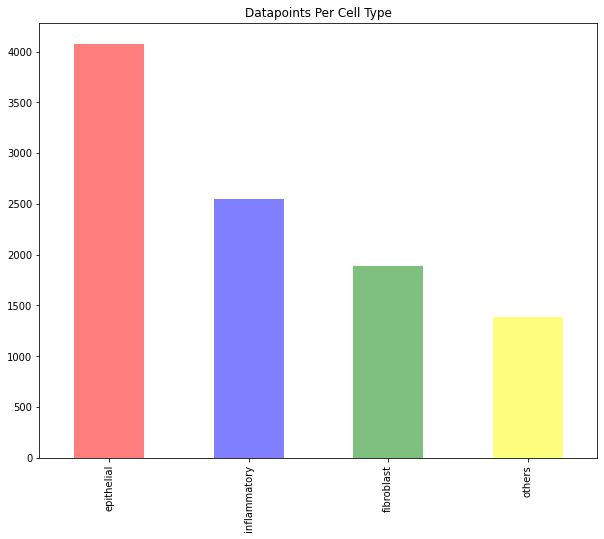

epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64


In [8]:
# Plot the number of datapoints by cell type
plt.figure(figsize=(10,8))
data['cellTypeName'].value_counts().plot(kind='bar', rot=0, color=['red', 'blue', 'green', 'yellow'], alpha=0.5)
plt.title("Datapoints Per Cell Type")
plt.xticks(rotation='vertical')

plt.show()

print(data['cellTypeName'].value_counts())

It can be see that there is imbalance in the frequencies of the different cell types, however, apart from the 'others' type, there is only little difference.

=======================================================

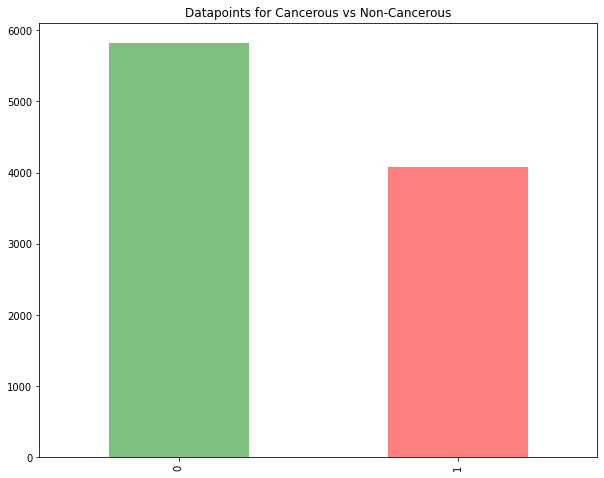

0    5817
1    4079
Name: isCancerous, dtype: int64


In [9]:
# Plot the number of datapoints based on whether the cell is cancerous or not
plt.figure(figsize=(10,8))
data['isCancerous'].value_counts().plot(kind='bar', rot=0, color=['green', 'red'], alpha=0.5)
plt.title("Datapoints for Cancerous vs Non-Cancerous")
plt.xticks(rotation='vertical')

plt.show()

print(data['isCancerous'].value_counts())

Above, there is an imbalance in the frequencies of datapoints that are labelled cancerous and non-cancerous, however this can be considered a small difference and is expected to cause little influence on the training of the model.

#### **Frequency of Cancerous & Non-Cancerous Cells vs Cell Type**

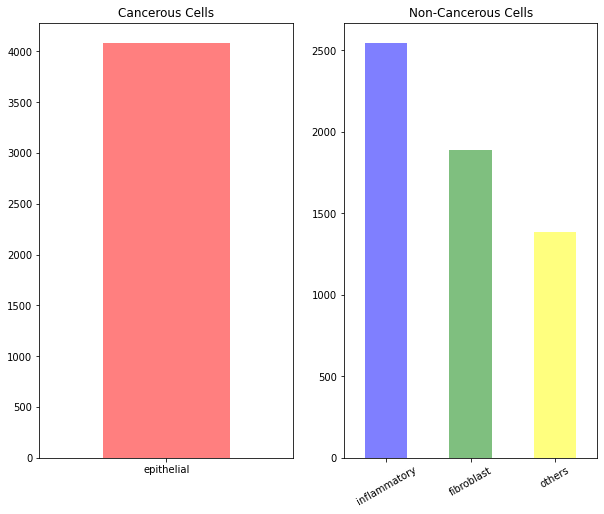

In [10]:
# Split data into cancerous and non-cancerous sets to be plotted
cancerousCellData = data[data['isCancerous'] == 1]
nonCancerousCellData = data[data['isCancerous'] == 0]

# Plotting the number of cancerous and non-cancerous cells against cell type
plt.figure(figsize=(10,8))

plt.subplot(1, 2, 1)
plt.title("Cancerous Cells")
cancerousCellData['cellTypeName'].value_counts().plot(kind='bar', rot=0, color=['red'], alpha=0.5)

plt.subplot(1, 2, 2)
plt.title("Non-Cancerous Cells")
nonCancerousCellData['cellTypeName'].value_counts().plot(kind='bar', rot=0, color=['blue', 'green', 'yellow'], alpha=0.5)
plt.xticks(rotation=30)

plt.show()

From the above data, it can be seen that almost all of the cells that have been labelled cancerous have been labelled the epithelial cell type, while the non-cancerous cells are of inflammatory, fibroblast and other cell types.

This indicates that training a model with this data will cause it to predict cancerous cells to be of epithelial cell type and epithelial cells to be cancerous.

# Data Pre-Processing

In [11]:
# Removes the 'InstanceID' column
data = data.drop(['InstanceID'], axis=1)

#### **Data Splitting**

In [12]:
# Split the data into train, validation and testing sets 
from sklearn.model_selection import train_test_split

test_size = int(len(data) * 0.1)
val_size = int(len(data) * 0.1)
train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=val_size, random_state=42)

print("Train data: {} | Validation Data: {} | Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data: 7918 | Validation Data: 989 | Test Data: 989


# **TASK 1:** Classification of Cancerous Cells



## **Defining Functions**



In [13]:
# Constant variables

IMAGE_SIZE = (27, 27)

# Images are 27x27 in size, and have 3 dimensions for the RGB colouring of each pixel
INPUT_DIM = (27, 27, 3)

# TESTING output for Cancerous & Non-Cancerous (2 classes)
OUTPUT_CLASSES = 2

In [18]:
# Image data generator function 
def generate_image_data(category, class_mode):

    # Convert types to string for the target value
    train_data[category] = train_data[category].astype('str')
    val_data[category] = val_data[category].astype('str')
    test_data[category] = test_data[category].astype('str')

    train_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
    val_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
    test_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
    
    batch_size = 32

    # Data generator for training set
    train_generator = train_datagen.flow_from_dataframe(
            dataframe = train_data,
            directory = '/content/patch_images',
            x_col = "ImageName",
            y_col = category,
            target_size = IMAGE_SIZE,
            batch_size = batch_size,
            class_mode = class_mode)

    # Data generator for validation set
    validation_generator = val_datagen.flow_from_dataframe(
            dataframe = val_data,
            directory = '/content/patch_images',
            x_col = "ImageName",
            y_col = category,
            target_size = IMAGE_SIZE,
            batch_size = batch_size,
            class_mode = class_mode)


    batch_size = 1

    # Data generator for testing set
    test_generator = test_datagen.flow_from_dataframe(
            dataframe = test_data,
            directory = '/content/patch_images',
            x_col = "ImageName",
            y_col = category,
            target_size = IMAGE_SIZE,
            batch_size = batch_size,
            class_mode = class_mode)
    
    return train_generator, validation_generator, test_generator

In [15]:
# Plot the learning curve 
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize = (20, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## **Baseline Model**
We have first constructed a very basic CNN model with 2 layers. Here we are expecting that our model will have overfitting problem and won't generalize the problem with great accuracy. 

In [19]:
# A simple CNN with 2 layers
model_CNN = Sequential([
    # Layer 1
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(27, 27, 3)),
    layers.MaxPooling2D((2, 2)),
    #Layer 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Flattening Layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# print out model summary and how many layers it has
model_CNN.summary()

# Build the model using defined architecture 
# lr -> 1e-3
model_CNN.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])

train_generator, validation_generator, test_generator = generate_image_data('isCancerous', 'binary')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               295040    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [21]:
history_CNN = model_CNN.fit(train_generator, batch_size=128,
                            epochs = 60,
                            validation_data = validation_generator,
                            verbose = 1)

Epoch 1/60
248/248 [==============================] - 2s 10ms/step - loss: 0.2864 - accuracy: 0.8804 - val_loss: 0.2676 - val_accuracy: 0.8898
Epoch 2/60
248/248 [==============================] - 3s 10ms/step - loss: 0.2930 - accuracy: 0.8809 - val_loss: 0.2662 - val_accuracy: 0.8857
Epoch 3/60
248/248 [==============================] - 2s 10ms/step - loss: 0.2745 - accuracy: 0.8853 - val_loss: 0.3196 - val_accuracy: 0.8675
Epoch 4/60
248/248 [==============================] - 3s 10ms/step - loss: 0.2832 - accuracy: 0.8838 - val_loss: 0.2591 - val_accuracy: 0.8918
Epoch 5/60
248/248 [==============================] - 2s 10ms/step - loss: 0.2547 - accuracy: 0.8981 - val_loss: 0.2687 - val_accuracy: 0.8898
Epoch 6/60
248/248 [==============================] - 2s 10ms/step - loss: 0.2464 - accuracy: 0.9015 - val_loss: 0.2591 - val_accuracy: 0.8948
Epoch 7/60
248/248 [==============================] - 3s 10ms/step - loss: 0.2476 - accuracy: 0.8972 - val_loss: 0.3387 - val_accuracy: 0.8443

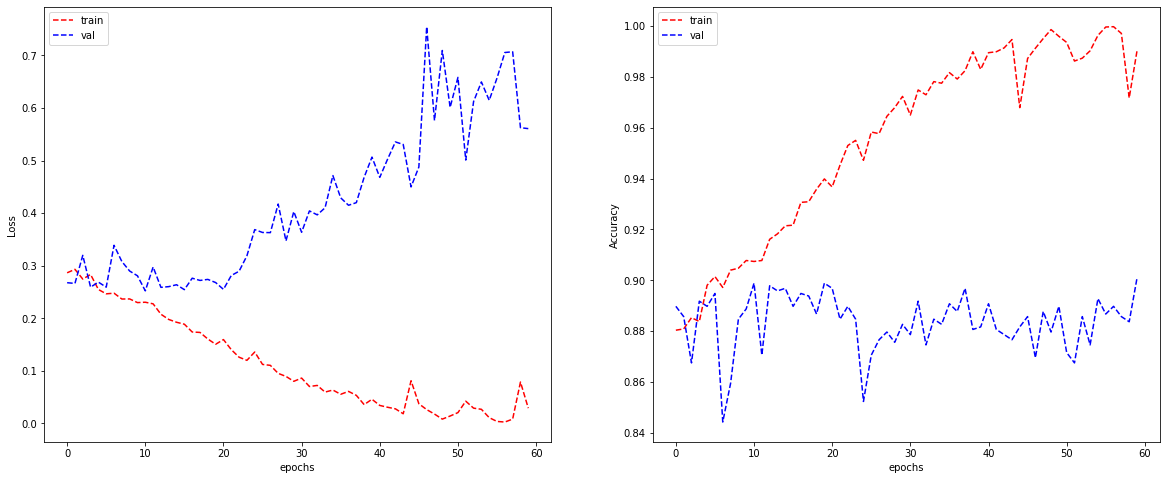

In [22]:
plot_learning_curve(history_CNN.history['loss'], history_CNN.history['val_loss'], 
                    history_CNN.history['accuracy'], history_CNN.history['val_accuracy'], 
                    metric_name='Accuracy')

As expected, our simple cnn is suffering from overfitting. Now we need to look at good model architecture to tackle the problem. 

## Bayesian CNN Model
A Bayesian Convolutional Neural Network

In [23]:
# Import tensor flow probability module 
import tensorflow_probability as tfp

divergence_fn = lambda q,p,_:tfp.distributions.kl_divergence(q,p)/7918 # divide by total number of training images

model_bayes = tf.keras.Sequential([
    
    tfp.layers.Convolution2DReparameterization(input_shape = (27, 27, 3), filters = 32, kernel_size = 3, activation = 'relu',
                                                kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                                kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular = False),
                                                kernel_divergence_fn = divergence_fn,
                                                bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                                bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular=False),
                                                bias_divergence_fn = divergence_fn
                                            ),
    tf.keras.layers.Conv2D(32, 3,(1, 1), kernel_initializer='he_normal',activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, 3,(1, 1), kernel_initializer='he_normal',activation='relu'),
    tf.keras.layers.Conv2D(64, 3,(1, 1), kernel_initializer='he_normal', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tfp.layers.DenseReparameterization(units = tfp.layers.OneHotCategorical.params_size(2), activation = None,
                                        kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                        kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular = False),
                                        kernel_divergence_fn = divergence_fn,
                                        bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                        bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular = False),
                                        bias_divergence_fn = divergence_fn
                                    ),
    tfp.layers.OneHotCategorical(2)
])

model_bayes.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization (C (None, 25, 25, 32)        1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)              

In [24]:
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [25]:
from tensorflow.keras.optimizers import Adam

model_bayes.compile(loss = negative_log_likelihood,
                    optimizer = 'adam', 
                    metrics = ['accuracy'])

In [26]:
# Regenerate image data
train_generator, validation_generator, test_generator = generate_image_data('isCancerous', 'categorical')

Found 7918 validated image filenames belonging to 2 classes.
Found 989 validated image filenames belonging to 2 classes.
Found 989 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [27]:
history_bayes = model_bayes.fit(train_generator, validation_data = validation_generator, epochs = 60, verbose = 1)

Epoch 1/60
248/248 [==============================] - 5s 14ms/step - loss: 1.5165 - accuracy: 0.6118 - val_loss: 1.4228 - val_accuracy: 0.6532
Epoch 2/60
248/248 [==============================] - 3s 12ms/step - loss: 1.4131 - accuracy: 0.6498 - val_loss: 1.4154 - val_accuracy: 0.6158
Epoch 3/60
248/248 [==============================] - 3s 12ms/step - loss: 1.3623 - accuracy: 0.6691 - val_loss: 1.3208 - val_accuracy: 0.6825
Epoch 4/60
248/248 [==============================] - 3s 12ms/step - loss: 1.3192 - accuracy: 0.6803 - val_loss: 1.3165 - val_accuracy: 0.6785
Epoch 5/60
248/248 [==============================] - 3s 12ms/step - loss: 1.2612 - accuracy: 0.7011 - val_loss: 1.2341 - val_accuracy: 0.7280
Epoch 6/60
248/248 [==============================] - 3s 12ms/step - loss: 1.2128 - accuracy: 0.7078 - val_loss: 1.2703 - val_accuracy: 0.6764
Epoch 7/60
248/248 [==============================] - 3s 12ms/step - loss: 1.1577 - accuracy: 0.7285 - val_loss: 1.1579 - val_accuracy: 0.7240

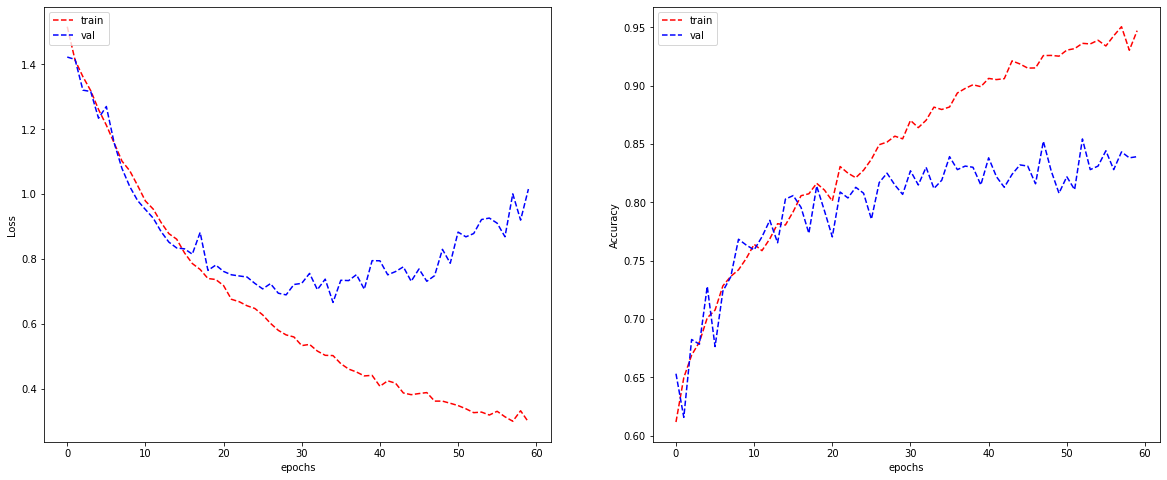

In [28]:
plot_learning_curve(history_bayes.history['loss'], history_bayes.history['val_loss'], 
                    history_bayes.history['accuracy'], history_bayes.history['val_accuracy'], 
                    metric_name = 'Accuracy')

In [29]:
model_bayes.evaluate(test_generator)

989/989 [==============================] - 4s 4ms/step - loss: 0.8169 - accuracy: 0.8696


[0.8168513178825378, 0.8695651888847351]

There is overfitting in our bayesian CNN model and it does not reach to our target performance score. We decided to move forward, since most of the literature stating that using CNN architecture like inceptionV3 will result in great accuracy.   

## **VGG Model**
A VGG CNN with 4 layers 

In [77]:
# Define VGG Architecture 
def VGG_n(input_shape, num_classes, include_top=True):
    """
    """
    model_vgg = Sequential([
        # Input layer 
        Input(input_shape),

        # Layer 1
        Conv2D(32, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),

        # Layer 2
        Conv2D(32, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Layer 3
        Conv2D(64, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),

        # Layer 4
        Conv2D(64, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Flatening Layer
        Flatten(),
        Dense(128, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.5),
    ])
    # sigmoid condition
    if include_top:
        model_vgg.add(Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid'))
    return model_vgg

In [54]:
# Regenerate image data
train_generator, validation_generator, test_generator = generate_image_data('isCancerous', 'binary')

Found 7918 validated image filenames belonging to 2 classes.
Found 989 validated image filenames belonging to 2 classes.
Found 989 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [78]:
# Build the model 
input_shape = (27, 27, 3)
model_VGG = VGG_n(input_shape, 1)
model_VGG.summary()

# Learning rate scheduler
learning_rate = 1e-3
# warmup_steps = 100
lr_drop = 25
epochs = 60

# Learning Rate Scheduler 
def lr_scheduler(epoch):
 return learning_rate * (0.5 ** (epoch // lr_drop))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                                   cooldown=0,
                                                   patience=5,
                                                   min_lr=0.5e-6)


# Compile the model
model_VGG.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
hist_vgg = model_VGG.fit(train_generator,
    batch_size=128,
    epochs=epochs,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[reduce_lr, lr_reducer]
)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_71 (Batc (None, 27, 27, 32)        128       
_________________________________________________________________
activation_71 (Activation)   (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_72 (Batc (None, 27, 27, 32)        128       
_________________________________________________________________
activation_72 (Activation)   (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 13, 13, 32)      

In [79]:
# Plot the learning curve 
def plot(hist_vgg):
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(hist_vgg.epoch, hist_vgg.history['accuracy'], label='training')
    plt.plot(hist_vgg.epoch, hist_vgg.history['val_accuracy'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(hist_vgg.epoch, hist_vgg.history['loss'], label='training')
    plt.plot(hist_vgg.epoch, hist_vgg.history['val_loss'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

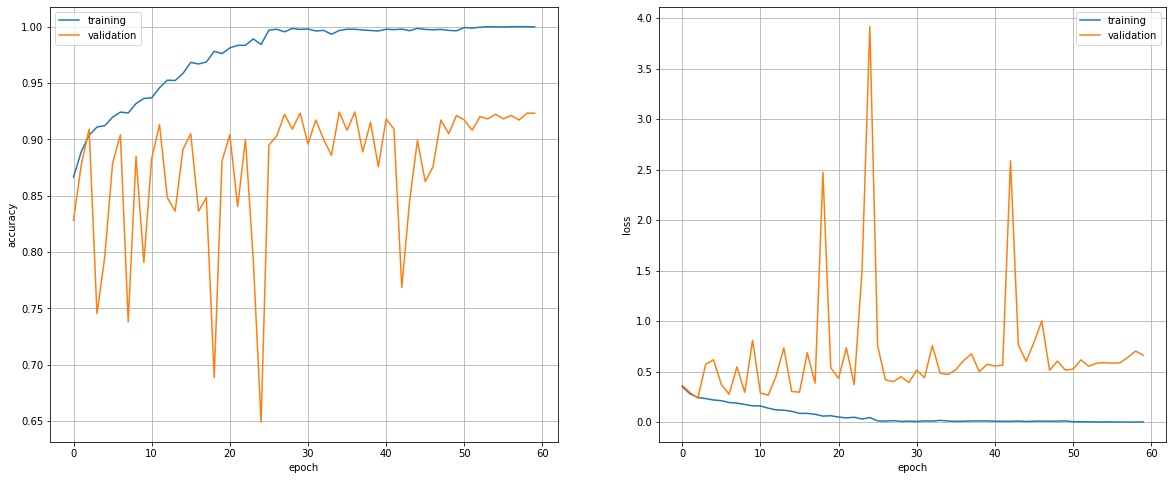

In [58]:
plot(hist_vgg)

In [80]:
# Predict using VGG_4 model
# setup data generator (may have done this before)
batch_size_ = 16
# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
threshold = 0.5
for x,y in validation_generator:
    
        y_hat = model_VGG.predict(x, verbose=0)
        #print(batches)
        # y_hat = np.argmax(y_hat, axis = 1)
        y_hat = np.squeeze(y_hat, 1)
        y_hat = (y_hat > threshold).astype('int32')
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()
       
        batches += len(x)
        if batches >= N_images:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [81]:
# Print F1 Score, Confusion Matrix and Accuracy Score 
print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.916076845298281
F1 score:  0.9134593589917948
[[539  39]
 [ 44 367]]


There is a huge overfitting in our vgg model. We have idenfied that doing Data Augementation will improve its performance. Therefore in next section we have applied data augmentation to the training set and observe the results.  

#### Data Augmentation for performnace improvement 

In [84]:
train_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last',    
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening= False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False # randomly flig images 
    )   
batch_size = 128
train_vgg_generator = train_datagen.flow_from_dataframe(
        dataframe = train_data,
        #directory = './Image_classification_data/patch_images',
        directory = '/content/patch_images',
        x_col = "ImageName",
        y_col = "isCancerous",
        target_size = IMAGE_SIZE,
        batch_size = batch_size,
        class_mode = 'binary')

Found 7918 validated image filenames belonging to 2 classes.


In [85]:
# Build the model 
input_shape = (27, 27, 3)
model_VGG_aug = VGG_n(input_shape, 1)
model_VGG_aug.summary()

# Learning rate scheduler
learning_rate = 1e-3
# warmup_steps = 100
lr_drop = 25
epochs = 200

def lr_scheduler(epoch):
 return learning_rate * (0.5 ** (epoch // lr_drop))
 reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
 lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                                   cooldown=0,
                                                   patience=5,
                                                   min_lr=0.5e-6)



# Compile the model
model_VGG_aug.compile(optimizer=optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
hist_vgg = model_VGG_aug.fit(
    train_vgg_generator,
    batch_size=128,
    epochs=epochs,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[reduce_lr, lr_reducer]
)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_83 (Batc (None, 27, 27, 32)        128       
_________________________________________________________________
activation_83 (Activation)   (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_84 (Batc (None, 27, 27, 32)        128       
_________________________________________________________________
activation_84 (Activation)   (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 13, 13, 32)      

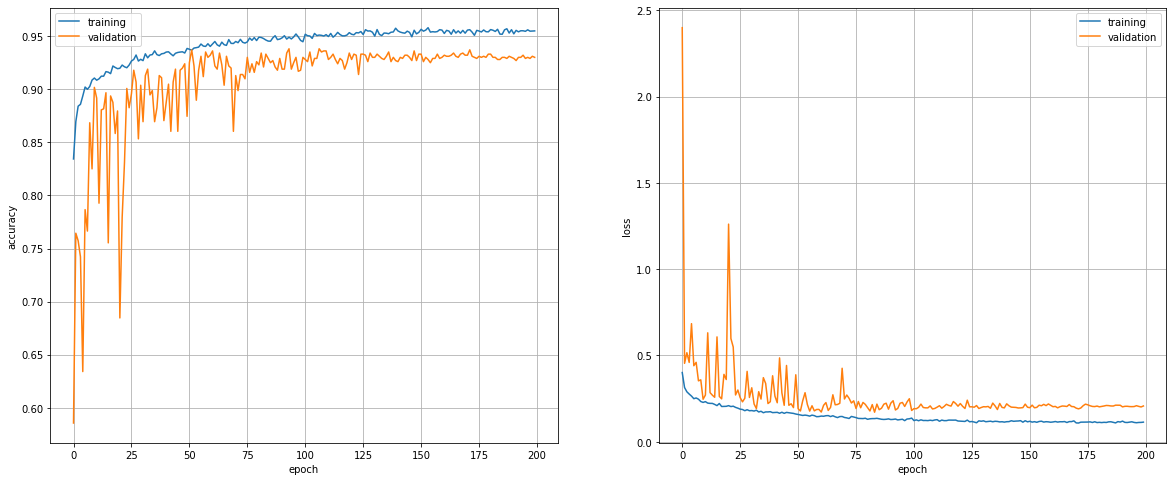

In [86]:
plot(hist_vgg)

Overfitting consederibly reduced due to data augmentation 

### Model Validation 



In [87]:
# Predict using VGG_4 model
# setup data generator (may have done this before)
batch_size_ = 16
# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
threshold = 0.5
for x,y in validation_generator:
    
        y_hat = model_VGG_aug.predict(x, verbose=0)
        #print(batches)
        # y_hat = np.argmax(y_hat, axis = 1)
        y_hat = np.squeeze(y_hat, 1)
        y_hat = (y_hat > threshold).astype('int32')
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()
       
        batches += len(x)
        if batches >= N_images:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [88]:
# Print F1 Score, Confusion Matrix and Accuracy Score 
print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
cm= confusion_matrix(y_true=y_all, y_pred=y_hat_all)
print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.9302325581395349
F1 score:  0.9275001407692055
[[556  22]
 [ 47 364]]


We have reached to our target performance score

Confusion Matirx 

In [89]:
# Plot Confusion Matrix (Adapted from sikit learn)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [90]:
cm_plot_labels = ['not_cancerous','cancerous']

Confusion matrix, without normalization
[[556  22]
 [ 47 364]]


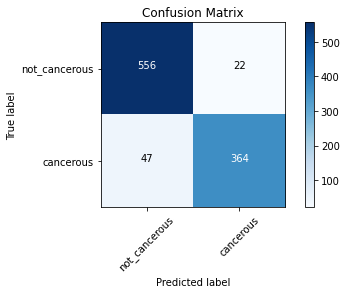

In [91]:
import itertools
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

From the confusion matirx:  
=> For Validation_data:
* TN=556,FP=22
* FN=47,TP=364


### Model Evaluation 

Now that we have reached to our target performance score with VGG model, it's time to evaluate our model on test set. 

In [92]:
# Model Evaluation on test set
test_loss, test_accuracy=model_VGG_aug.evaluate(test_generator)
print('Test loss: {} Test accuracy: {}'.format(test_loss, test_accuracy))

989/989 [==============================] - 3s 3ms/step - loss: 0.2120 - accuracy: 0.9272
Test loss: 0.2119593322277069 Test accuracy: 0.9271991848945618


In [93]:
# Predict using VGG_4 model
# setup data generator (may have done this before)
batch_size_ = 16
# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
threshold = 0.5 # Decision threshold 
for x,y in test_generator:
    
        y_hat = model_VGG_aug.predict(x, verbose=0)
        #print(batches)
        # y_hat = np.argmax(y_hat, axis = 1)
        y_hat = np.squeeze(y_hat, 1)
        y_hat = (y_hat > threshold).astype('int32')
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()
       
        batches += len(x)
        if batches >= N_images:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [94]:
# Print F1 Score, Confusion Matrix and Accuracy Score 
print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
cm= confusion_matrix(y_true=y_all, y_pred=y_hat_all)
print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.9271991911021233
F1 score:  0.9243787434688415
[[554  30]
 [ 42 363]]


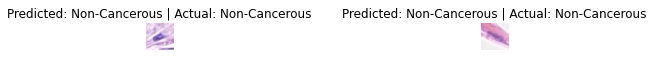

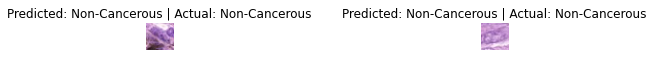

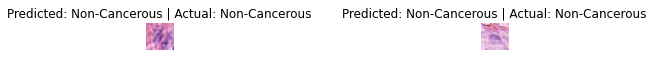

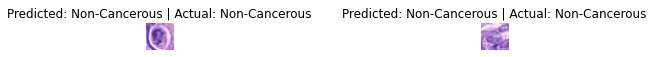

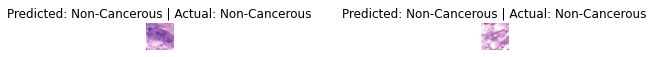

In [95]:
# Plot the predicted results against the actual data on the test set
label_names = {'Non-Cancerous' : 0, 'Cancerous' : 1}

z = 0
while z < 5:
  d_inv = {v: k for k, v in label_names.items()}
  plt.figure(figsize=(17, 0.5))
  batches = 0
  for x, y in test_generator:
          batches = batches + 1
          y_hat = model_VGG_aug.predict(x, verbose=0)
          y_hat = np.squeeze(y_hat, 1)
          x = np.squeeze(x)
          if batches < 3:
              plt.subplot(1, 3, batches)
              plt.imshow(x)
              plt.title("Predicted: {} | Actual: {}".format(d_inv[np.argmax(y_hat[0])], d_inv[np.argmax(y[0])]))
              
          else:
              break
          
          plt.axis('off')

  z = z + 1

We can see that the our model has performed well on test data set and also reached the target performance. Now we will move forward to tasks 2.

# **TASK 2:** 'cellType' Classification 

Data Preparation 

In [96]:
data_dir = Path('/content')
train_label_path = data_dir / 'data_labels_mainData.csv'

train_label_df = pd.read_csv(train_label_path)


train_label_df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [98]:
# Data Loader 
def load_categorical_data(label_df, image_dir):
    """Load data from given label data frame and image dir
    """
    image_dir = Path(image_dir)
    image_filenames = label_df.ImageName.values
    cell_type_names = label_df.cellTypeName.values
    cell_type = label_df.cellType.values

    name_type_pairs = set(list(zip(cell_type_names, cell_type)))
    name_type_pairs = sorted(name_type_pairs, key=lambda x: x[1])
    classes = [x[0] for x in name_type_pairs]
    class_map = dict(name_type_pairs)
    id2class = {class_id: class_name for class_name, class_id in class_map.items()}

    images = []
    labels = []
    for i in range(len(image_filenames)):
        filename = image_filenames[i]

        image_path = image_dir / filename
        image = np.array(Image.open(image_path))
        images.append(image)
        labels.append(cell_type[i])

    images = np.stack(images, 0)
    labels = np.stack(labels, 0)
    return images, labels, id2class, classes


image_dir = data_dir / 'patch_images'
images, labels, id2class, classes = load_categorical_data(train_label_df, image_dir)

print('images shape: {} labels shape: {}'.format(images.shape, labels.shape))
print('Classes:', classes)

images shape: (9896, 27, 27, 3) labels shape: (9896,)
Classes: ['fibroblast', 'inflammatory', 'epithelial', 'others']


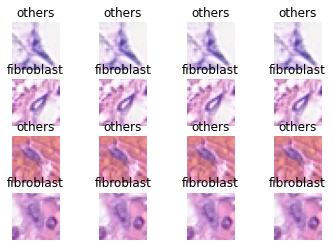

In [99]:
# Lets have a look at some of the images  
_, axes = plt.subplots(4, 4)
indices = np.random.choice(len(images), 16)
image_samples = images[indices]
label_samples = labels[indices]
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(image_samples[i])
        axes[i, j].axis('off')
        axes[i, j].set_title(str(id2class[label_samples[i]]))
plt.show()

## Image Preprocessing & Normalization 

In [100]:
test_size = int(len(labels) * 0.1)
val_size = int(len(labels) * 0.1)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=test_size, random_state=12)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=val_size, random_state=12)

train_images = train_images.astype('float32') / 255.
val_images = val_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

print('train_images shape: {} train_labels shape: {}'.format(train_images.shape, train_labels.shape))
print('val_images shape: {} val_labels shape: {}'.format(val_images.shape, val_labels.shape))
print('test_images shape: {} test_labels shape: {}'.format(test_images.shape, test_labels.shape))

train_images shape: (7918, 27, 27, 3) train_labels shape: (7918,)
val_images shape: (989, 27, 27, 3) val_labels shape: (989,)
test_images shape: (989, 27, 27, 3) test_labels shape: (989,)


## Baseline Model
Again, we have first constructed a very basic CNN model with 2 layers. Here we are expecting that our model will have overfitting problem and won't geenralize the problem with great accuracy.

In [101]:
model_CNN_1 = Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(27, 27, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model_CNN_1.summary()
model_CNN_1.compile(optimizer=optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist_CNN_1 = model_CNN_1.fit(
    train_images, train_labels,
    batch_size=32,
    epochs=60,
    validation_data=(val_images, val_labels),
    verbose=1
)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               295040    
_________________________________________________________________
dense_51 (Dense)             (None, 4)               

In [102]:
# Plot the learning curve 
def plot(hist_CNN_1):
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(hist_CNN_1.epoch, hist_CNN_1.history['accuracy'], label='training')
    plt.plot(hist_CNN_1.epoch, hist_CNN_1.history['val_accuracy'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(hist_CNN_1.epoch, hist_CNN_1.history['loss'], label='training')
    plt.plot(hist_CNN_1.epoch, hist_CNN_1.history['val_loss'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

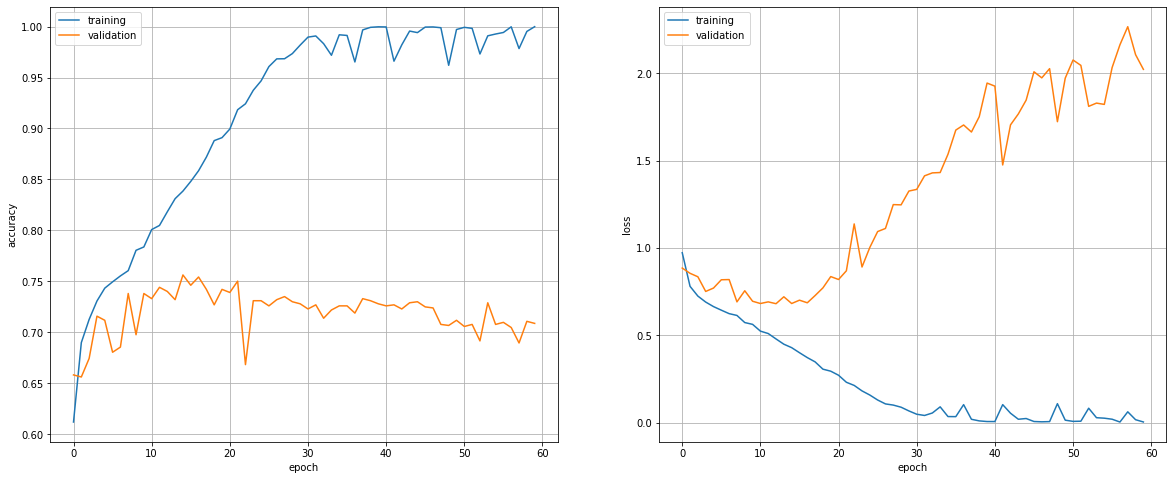

In [ ]:
plot(hist_CNN_1)

In [103]:
val_loss, val_accuracy = model_CNN_1.evaluate(val_images, val_labels)
print('Test loss: {} Test accuracy: {}'.format(val_loss, val_accuracy))

y_pred = model_CNN_1.predict(val_images)
y_pred = np.argmax(y_pred, 1)
f1 = f1_score(val_labels, y_pred, average='macro')
print('F1-score:', f1)
print(confusion_matrix(val_labels, y_pred))

31/31 [==============================] - 0s 2ms/step - loss: 2.2016 - accuracy: 0.7351
Test loss: 2.2015626430511475 Test accuracy: 0.7350859642028809
F1-score: 0.697463366389325
[[149  23  31  14]
 [ 21 197  31  21]
 [ 17  19 312   7]
 [ 22  39  17  69]]


We can see that simple cnn can not perform well as expected. 

## Bayesian CNN Model

In [104]:
import tensorflow_probability as tfp

divergence_fn = lambda q,p,_:tfp.distributions.kl_divergence(q,p)/7918 # divide by total number of training images, pValue-3457

celltype_model_bayes = tf.keras.Sequential([
    
    tfp.layers.Convolution2DReparameterization(input_shape = (27, 27, 3), filters = 32, kernel_size = 3, activation = 'relu',
                                                kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                                kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular = False),
                                                kernel_divergence_fn = divergence_fn,
                                                bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                                bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular=False),
                                                bias_divergence_fn = divergence_fn
                                            ),
    tf.keras.layers.Conv2D(32, 3,(1, 1), kernel_initializer='he_normal',activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, 3,(1, 1), kernel_initializer='he_normal',activation='relu'),
    tf.keras.layers.Conv2D(64, 3,(1, 1), kernel_initializer='he_normal', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tfp.layers.DenseReparameterization(units = tfp.layers.OneHotCategorical.params_size(4), activation = None,
                                        kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                        kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular = False),
                                        kernel_divergence_fn = divergence_fn,
                                        bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
                                        bias_posterior_fn = tfp.layers.default_mean_field_normal_fn(is_singular = False),
                                        bias_divergence_fn = divergence_fn
                                    ),
    tfp.layers.OneHotCategorical(4)
])


celltype_model_bayes.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_1  (None, 25, 25, 32)        1792      
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 23, 23, 32)        9248      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 576)             

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [105]:
celltype_model_bayes.compile(loss = negative_log_likelihood,
                                    optimizer = 'adam',
                                    metrics = ['accuracy'],
                                    experimental_run_tf_function = False)

# Generate image data
train_generator, validation_generator, test_generator = generate_image_data('cellType', 'categorical')

Found 7918 validated image filenames belonging to 4 classes.
Found 989 validated image filenames belonging to 4 classes.
Found 989 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [106]:
history_celltype_model_bayes = celltype_model_bayes.fit(train_generator, validation_data = validation_generator, epochs = 60, verbose = 1)

Epoch 1/60
248/248 [==============================] - 5s 13ms/step - loss: 2.1339 - accuracy: 0.3639 - val_loss: 2.0449 - val_accuracy: 0.3620
Epoch 2/60
248/248 [==============================] - 3s 12ms/step - loss: 1.9306 - accuracy: 0.4494 - val_loss: 1.9395 - val_accuracy: 0.4125
Epoch 3/60
248/248 [==============================] - 3s 12ms/step - loss: 1.8562 - accuracy: 0.4715 - val_loss: 1.8368 - val_accuracy: 0.4995
Epoch 4/60
248/248 [==============================] - 3s 12ms/step - loss: 1.7969 - accuracy: 0.4883 - val_loss: 1.7505 - val_accuracy: 0.4894
Epoch 5/60
248/248 [==============================] - 3s 12ms/step - loss: 1.7146 - accuracy: 0.5048 - val_loss: 1.7019 - val_accuracy: 0.5177
Epoch 6/60
248/248 [==============================] - 3s 12ms/step - loss: 1.6590 - accuracy: 0.5330 - val_loss: 1.6418 - val_accuracy: 0.5187
Epoch 7/60
248/248 [==============================] - 3s 12ms/step - loss: 1.6173 - accuracy: 0.5378 - val_loss: 1.6052 - val_accuracy: 0.5703

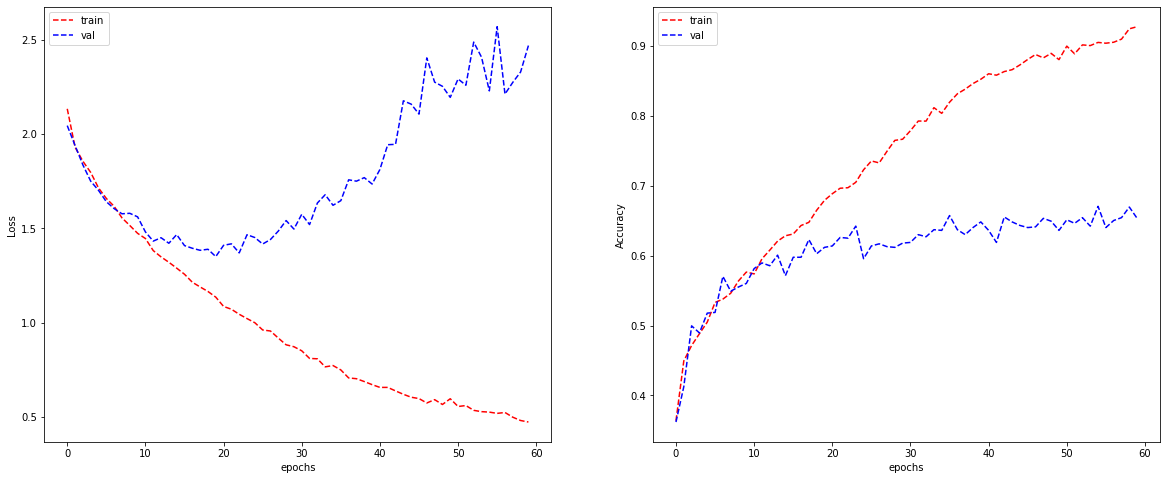

In [107]:
plot_learning_curve(history_celltype_model_bayes.history['loss'], history_celltype_model_bayes.history['val_loss'], 
                    history_celltype_model_bayes.history['accuracy'], history_celltype_model_bayes.history['val_accuracy'], 
                    metric_name='Accuracy')

In [108]:
# Performance measure 
celltype_model_bayes.evaluate(test_generator)

989/989 [==============================] - 4s 4ms/step - loss: 2.3676 - accuracy: 0.6775


[2.367610216140747, 0.6774519681930542]

For task 2 our bayesian model suffers from huge overfitting. So we decided to move foraward with VGG architecture

## VGG for cellType



In [110]:
# VGG with 4 layers
# Define VGG Architecture 
def VGG_n(input_shape, num_classes, include_top=True):
    """
    """
    model_vgg = Sequential([
        # Input layer 
        Input(input_shape),

        # Layer 1
        Conv2D(32, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),

        # Layer 2
        Conv2D(32, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Layer 3
        Conv2D(64, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),

        # Layer 4
        Conv2D(64, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Flatening Layer
        Flatten(),
        Dense(128, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.5),
    ])
    # sigmoid condition
    if include_top:
        model_vgg.add(Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid'))
    return model_vgg

In [115]:
# Build the model 
input_shape = (27, 27, 3)
model_VGG = VGG_n(input_shape, 4)
model_VGG.summary()

# Learning rate scheduler
learning_rate = 1e-3
# warmup_steps = 100
lr_drop = 25
epochs = 60

# Learning Rate Scheduler 
def lr_scheduler(epoch):
 return learning_rate * (0.5 ** (epoch // lr_drop))

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                                   cooldown=0,
                                                   patience=5,
                                                   min_lr=0.5e-6)


# Compile the model
model_VGG.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist_vgg = model_VGG.fit(
    train_images,train_labels,
    batch_size=128,
    epochs=epochs,
    validation_data=(val_images,val_labels),
    verbose=1,
    callbacks=[reduce_lr, lr_reducer]
)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_99 (Batc (None, 27, 27, 32)        128       
_________________________________________________________________
activation_99 (Activation)   (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_100 (Bat (None, 27, 27, 32)        128       
_________________________________________________________________
activation_100 (Activation)  (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 13, 13, 32)      

In [116]:
# Plot the learning curve 
def plot(hist_vgg):
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(hist_vgg.epoch, hist_vgg.history['accuracy'], label='training')
    plt.plot(hist_vgg.epoch, hist_vgg.history['val_accuracy'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(hist_vgg.epoch, hist_vgg.history['loss'], label='training')
    plt.plot(hist_vgg.epoch, hist_vgg.history['val_loss'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

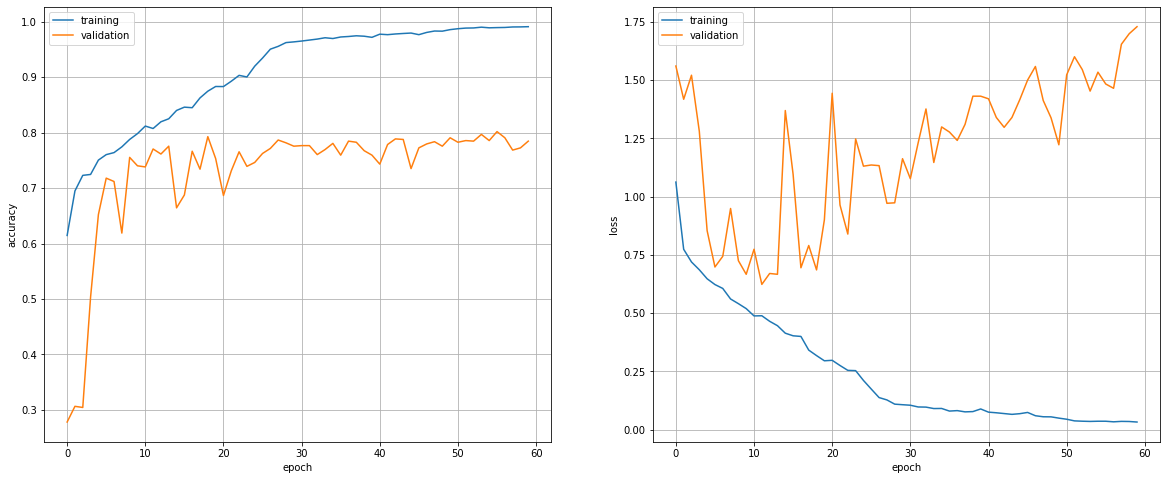

In [117]:
plot(hist_vgg)

In [118]:
# Show F1-Score
y_pred = model_VGG.predict(val_images)
y_pred = np.argmax(y_pred, 1)
f1 = f1_score(val_labels, y_pred, average='macro')
cm = confusion_matrix(val_labels, y_pred)
print('F1-score:', f1)
print(confusion_matrix(val_labels, y_pred))

F1-score: 0.7495220954017159
[[156  28  30   3]
 [ 10 217  22  21]
 [ 10  14 329   2]
 [ 17  39  17  74]]


Our model is suffering from overfitting, also our accuracy and f1-score did not reach to the traget performance metrics. 

#### Data Augmentation for performance improvement

Since there are slight class imbalances, we wanted to check how class weights are distributed among themselves.  

In [129]:
# Print the current weight of the classes 
counter = train_label_df.cellType.value_counts()
count_dict = dict(zip(counter.index, counter.values))

total_samples = train_label_df.shape[0]
num_classes = len(count_dict)
mul_class_weights = {}
for class_id, cnt in count_dict.items():
    mul_class_weights[class_id] = total_samples / (num_classes * cnt)

print(mul_class_weights)

{2: 0.6065212061779848, 1: 0.9728666928824223, 0: 1.3103813559322033, 3: 1.784992784992785}


In [119]:
# Define VGG Architecture 
def VGG_c(input_shape, num_classes, include_top=True):

    model_vgg_1 = Sequential([
        # Input layer 
        Input(input_shape),

        # Layer 1
        Conv2D(32, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),

        # Layer 2
        Conv2D(32, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Layer 3
        Conv2D(64, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),

        # Layer 4
        Conv2D(64, 3, 1, padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        # Flatening Layer
        Flatten(),
        Dense(128, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.5),
    ])
    # sigmoid condition
    if include_top:
        model_vgg_1.add(Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid'))
    return model_vgg_1

In [120]:
input_shape = (27, 27, 3)
model_VGG_1 = VGG_c(input_shape, 4) # 4 classes 
model_VGG_1.summary()

# Learning rate scheduler
learning_rate = 1e-3
#warmup_steps = 100
lr_drop = 25
epochs = 60
#batch_size_vgg=128

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                                   cooldown=0,
                                                   patience=5,
                                                   min_lr=0.5e-6)

# Data augmentation
data_aug = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

data_aug.fit(train_images)

model_VGG_1.compile(optimizer=optimizers.Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist_VGG_1 = model_VGG_1.fit(
    data_aug.flow(train_images, train_labels,batch_size=128),
    #batch_size=batch_size_vgg,
    epochs=epochs,
    validation_data=(val_images, val_labels),
    verbose=1,
    callbacks=[reduce_lr, lr_reducer]
)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_103 (Bat (None, 27, 27, 32)        128       
_________________________________________________________________
activation_103 (Activation)  (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_104 (Bat (None, 27, 27, 32)        128       
_________________________________________________________________
activation_104 (Activation)  (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 13, 13, 32)      

In [121]:
# plot learning curve 
def plot(hist_VGG_1):
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(hist_VGG_1.epoch, hist_VGG_1.history['accuracy'], label='training')
    plt.plot(hist_VGG_1.epoch, hist_VGG_1.history['val_accuracy'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(hist_VGG_1.epoch, hist_VGG_1.history['loss'], label='training')
    plt.plot(hist_VGG_1.epoch, hist_VGG_1.history['val_loss'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

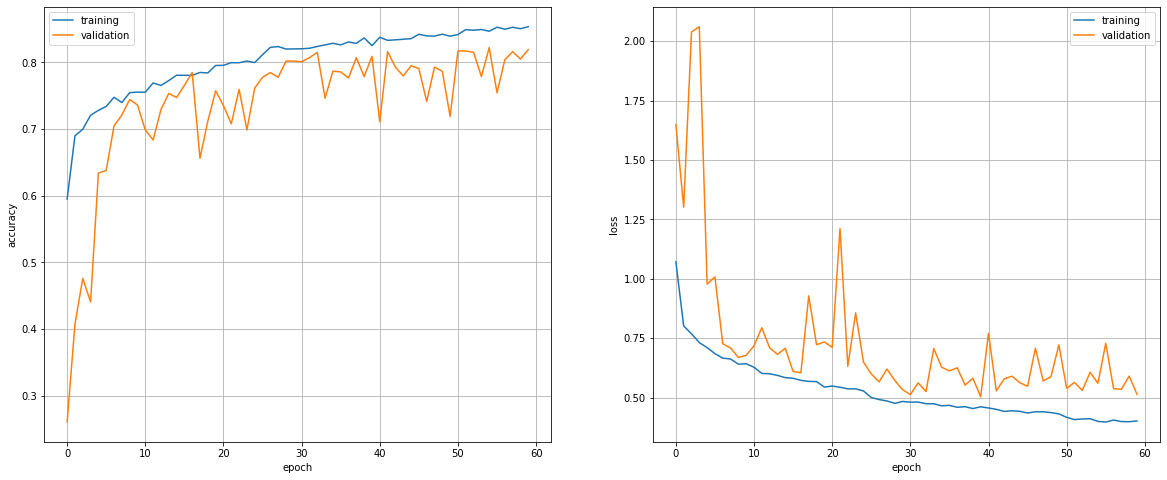

In [ ]:
plot(hist_VGG_1)

Overfitting has been reduced due to data augmentation. This is good a good sign. Now lets validate our model first.

### Model Validation

In [122]:
val_loss, val_accuracy = model_VGG_1.evaluate(val_images, val_labels)
print('val loss: {} val accuracy: {}'.format(val_loss, val_accuracy))

y_pred = model_VGG_1.predict(val_images)
y_pred = np.argmax(y_pred, 1)
f1 = f1_score(val_labels, y_pred, average='macro')
cm = confusion_matrix(val_labels, y_pred)
print('F1-score:', f1)
print(confusion_matrix(val_labels, y_pred))

31/31 [==============================] - 0s 3ms/step - loss: 0.5749 - accuracy: 0.8049
val loss: 0.5748868584632874 val accuracy: 0.8048533797264099
F1-score: 0.7703812671311562
[[141  21  32  23]
 [  6 225  19  20]
 [  6   7 342   0]
 [  9  30  20  88]]


Confusion Matrix 

In [123]:
# Plot Confusion Matrix (Adapted from sikit learn)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [124]:
cm_plot_labels = [ 'fibroblast','inflammatory','epithelial','others' ]

Confusion matrix, without normalization
[[141  21  32  23]
 [  6 225  19  20]
 [  6   7 342   0]
 [  9  30  20  88]]


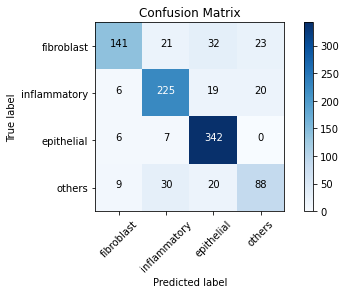

In [125]:
import itertools
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Though the overfitting reduced significantly but we still haven't reach to our target performance f1-score. Now We have decided to use transfer learning technique to improve the f1 score of our vgg model.    

### Transfer Learning 
We have tried the following two aproaches of transfer learning techniques: 
1. Train a model with provided extra datasets to create a base model, we freeze some layers in our new model and pass the weights to train and predict with that model.

2. We need to map or store the weights since our classes in both tasks are different. For this, we first created a base model using extra dataset, then we grabed the weights from global max pooling layer. We pass this weights to our new model to classify the images.   

#### EDA on Extra Dataset 

In [126]:
# data loader for transfer learning 
def load_data(label_df, image_dir):
    """Load data from given label data frame and image dir
    """
    image_dir = Path(image_dir)
    image_filenames = label_df.ImageName.values
    targets = label_df.isCancerous.values

    images = []
    labels = []
    for i in range(len(image_filenames)):
        filename = image_filenames[i]
        label = targets[i]

        image_path = image_dir / filename
        image = np.array(Image.open(image_path))
        images.append(image)
        labels.append(label)
    images = np.stack(images, 0)
    labels = np.stack(labels, 0)
    return images, labels

In [127]:
data_dir = Path('/content')
train_extra_label_path = data_dir / 'data_labels_extraData.csv'

train_extra_label_df = pd.read_csv(train_extra_label_path)

image_dir = data_dir / 'patch_images'
extra_images, extra_labels = load_data(train_extra_label_df, image_dir)

# Normalize
extra_labels = extra_labels.astype('int32')
print('images shape: {} labels shape: {}'.format(extra_images.shape, extra_labels.shape))

images shape: (10384, 27, 27, 3) labels shape: (10384,)


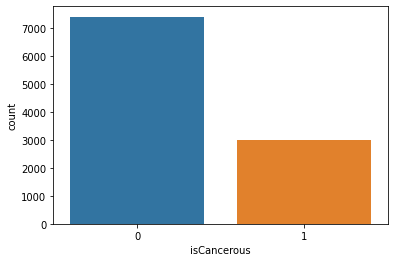

In [128]:
sns.countplot(x=train_extra_label_df.isCancerous)

We can see that there is class imbalances. We will class_weight to solve this problem. 

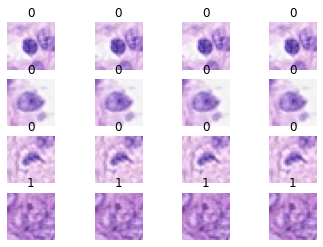

In [130]:
# Lets visualize some data 
_, axes = plt.subplots(4, 4)
indices = np.random.choice(len(extra_images), 16)
image_samples = extra_images[indices]
label_samples = extra_labels[indices]
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(image_samples[i])
        axes[i, j].axis('off')
        axes[i, j].set_title(label_samples[i])
plt.show()

#### Data Preprocessing

In [131]:
# spliting the data into train, test, validation 
extra_train_images, extra_val_images, extra_train_labels, extra_val_labels = train_test_split(extra_images, extra_labels, test_size=0.1, shuffle=True, random_state=12)

extra_train_images = extra_train_images.astype('float32') / 255.
extra_val_images = extra_val_images.astype('float32') / 255.

print('train_images shape: {} train_labels shape: {}'.format(extra_train_images.shape, extra_train_labels.shape))
print('val_images shape: {} val_labels shape: {}'.format(extra_val_images.shape, extra_val_labels.shape))

train_images shape: (9345, 27, 27, 3) train_labels shape: (9345,)
val_images shape: (1039, 27, 27, 3) val_labels shape: (1039,)


#### Approach 1

In [132]:
# Check class  weights 
counter = train_extra_label_df.isCancerous.value_counts()
count_dict = dict(zip(counter.index, counter.values))

total_samples = train_extra_label_df.shape[0]
num_classes = len(count_dict)
class_weights = {}
for class_id, cnt in count_dict.items():
    class_weights[class_id] = total_samples / (num_classes * cnt)

print(class_weights)

{0: 0.7021909656478226, 1: 1.7364548494983278}


In [133]:
input_shape = (27, 27, 3)
model_training_vgg = VGG_c(input_shape, num_classes=1)
model_training_vgg.summary()

# Learning rate scheduler
learning_rate = 1e-3
lr_drop = 25
epochs = 60

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Data augmentation
data_mut = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False  # randomly flip images
)
checkpoint_dir = './pretrained_models'
if os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, 'trans_vgg_model_{epoch:03d}_{val_accuracy:.4f}.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_prefix,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=True)

data_mut.fit(extra_train_images)
model_training_vgg.compile(optimizer=optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Applied class weights so that minor class gets more attention
hist_vgg_transfer = model_training_vgg.fit(
    data_mut.flow(extra_train_images, extra_train_labels,batch_size=128),
    epochs=epochs,
    validation_data=(extra_val_images, extra_val_labels),
    verbose=1,
    callbacks=[reduce_lr, checkpoint],
    class_weight= {
        0:1,
        1:1.5
    }
)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_107 (Bat (None, 27, 27, 32)        128       
_________________________________________________________________
activation_107 (Activation)  (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_108 (Bat (None, 27, 27, 32)        128       
_________________________________________________________________
activation_108 (Activation)  (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 13, 13, 32)      

In [134]:
def load_weights(model_dir, best=True):
    """
    """
    weight_files = os.listdir(model_dir)
    if best:
        weight_file = os.path.join(model_dir, sorted(weight_files, key=lambda x: float(x.split('_')[-1][:-3]))[::-1][0])
    else:
        weight_file = os.path.join(model_dir, weight_files[-1])
    return weight_file

Compute the balanced class weight for 4 classes

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels),
                                                 train_labels)

print(class_weights)

[1.31615691 0.97753086 0.60003031 1.81605505]


We have matched this value to previous class weight, they are all same.So we don't need to apply class weights in this case. 

In [138]:
input_shape = (27, 27, 3)
model_dir = './pretrained_models'
weight_file = load_weights(model_dir)
print('Loading from {}'.format(weight_file))

# Initiate the weights
trans_model = VGG_c(input_shape, 1)
trans_model.load_weights(weight_file)
trans_model = VGG_c(input_shape, 4, include_top=False)

for i in range(len(trans_model.layers)):
    if len(trans_model.layers[i].get_weights()) > 0:
        print(trans_model.layers[i].name)
        trans_model.layers[i].set_weights(trans_model.layers[i].get_weights())

        # Sanity check
        if len(trans_model.layers[i].get_weights()) > 0:
            for j in range(len(trans_model.layers[i].get_weights())):
                assert np.sum(np.abs(trans_model.layers[i].get_weights()[j] - trans_model.layers[i].get_weights()[j])) < 1e-5


for layer in trans_model.layers:
    layer.trainable = True

inputs = Input(input_shape)
x = trans_model(inputs, training=False) # freezing layers 
x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.1)(x)
outputs = Dense(4, activation='softmax')(x)


model = tf.keras.Model(inputs, outputs)
model.summary()

# Learning rate scheduler
learning_rate = 1e-3
lr_drop = 25
epochs = 200


def lr_scheduler(epoch):
    decay_lr =  learning_rate * (0.1 ** (epoch // lr_drop))
    print('Learning rate: {}'.format(decay_lr))
    return decay_lr

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                                   cooldown=0,
                                                   patience=5,
                                                   min_lr=0.5e-6)

# Data augmentation
data_mut = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zoom_range =0.2,
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

data_mut.fit(train_images)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
fine_tune_hist = model.fit(
    data_mut.flow(train_images, train_labels,batch_size=128),
    epochs=epochs,
    validation_data=(val_images, val_labels),
    verbose=1,
    callbacks=[reduce_lr, lr_reducer]

)

Loading from ./pretrained_models/trans_vgg_model_040_0.9394.h5
conv2d_127
batch_normalization_115
conv2d_128
batch_normalization_116
conv2d_129
batch_normalization_117
conv2d_130
batch_normalization_118
dense_67
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 27, 27, 3)]       0         
_________________________________________________________________
sequential_34 (Sequential)   (None, 128)               361376    
_________________________________________________________________
dense_68 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 4)                 260       
Total params: 369,892
Trainable params: 369,508

#### Performance Measures

In [139]:
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print('val loss: {} val accuracy: {}'.format(val_loss, val_accuracy))

y_pred = model.predict(val_images)
y_pred = np.argmax(y_pred, 1)
f1 = f1_score(val_labels, y_pred, average='macro')
print('F1-score:', f1)
print(confusion_matrix(val_labels, y_pred))

31/31 [==============================] - 0s 3ms/step - loss: 0.5319 - accuracy: 0.8140
val loss: 0.5319399833679199 val accuracy: 0.8139534592628479
F1-score: 0.7836699100807724
[[168  23  19   7]
 [ 13 228  14  15]
 [  9  15 327   4]
 [ 14  34  17  82]]


In [140]:
print(classification_report(val_labels,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       217
           1       0.76      0.84      0.80       270
           2       0.87      0.92      0.89       355
           3       0.76      0.56      0.64       147

    accuracy                           0.81       989
   macro avg       0.80      0.77      0.78       989
weighted avg       0.81      0.81      0.81       989



#### Approach 2

Base Model

In [158]:
# declare input shape 
input = tf.keras.Input(shape=(27,27,3))
# Block 1
x = tf.keras.layers.Conv2D(32, 3, strides=1, padding='same', activation="relu")(input)

x = tf.keras.layers.Conv2D(32, 3, strides=1, padding='same' ,activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same' ,activation="relu")(x)
x = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same' ,activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, 3, strides=1, padding='same' ,activation="relu")(x)
x = tf.keras.layers.Conv2D(128, 3, strides=1, padding='same' ,activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

# Now that we apply global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(x)


# Finally, we add a classification layer.
output = tf.keras.layers.Dense(1, activation='sigmoid')(gap)
dropout = tf.keras.layers.Dropout(0.5)(output)

# bind all
func_model = tf.keras.Model(input, output)
func_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 27, 27, 3)]       0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 6, 6, 64)          0   

In [159]:
# compile 
func_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# fit 
func_model.fit( data_mut.flow(extra_train_images, extra_train_labels), validation_data=(extra_val_images, extra_val_labels), batch_size=128, epochs=60)

Epoch 1/60
293/293 [==============================] - 5s 16ms/step - loss: 0.4268 - accuracy: 0.7966 - val_loss: 0.3065 - val_accuracy: 0.8884
Epoch 2/60
293/293 [==============================] - 5s 16ms/step - loss: 0.2740 - accuracy: 0.8883 - val_loss: 0.2920 - val_accuracy: 0.8941
Epoch 3/60
293/293 [==============================] - 5s 16ms/step - loss: 0.2456 - accuracy: 0.8982 - val_loss: 0.2455 - val_accuracy: 0.9115
Epoch 4/60
293/293 [==============================] - 5s 16ms/step - loss: 0.2549 - accuracy: 0.8933 - val_loss: 0.3063 - val_accuracy: 0.8970
Epoch 5/60
293/293 [==============================] - 5s 16ms/step - loss: 0.2475 - accuracy: 0.8990 - val_loss: 0.2374 - val_accuracy: 0.9143
Epoch 6/60
293/293 [==============================] - 5s 16ms/step - loss: 0.2225 - accuracy: 0.9095 - val_loss: 0.2331 - val_accuracy: 0.9115
Epoch 7/60
293/293 [==============================] - 5s 16ms/step - loss: 0.2215 - accuracy: 0.9164 - val_loss: 0.2265 - val_accuracy: 0.9153

In [160]:
# Print all layers
for i, layer in enumerate(func_model.layers):
    print(i,'\t',layer.trainable,'\t  :',layer.name)

0 	 True 	  : input_33
1 	 True 	  : conv2d_137
2 	 True 	  : conv2d_138
3 	 True 	  : max_pooling2d_73
4 	 True 	  : conv2d_139
5 	 True 	  : conv2d_140
6 	 True 	  : max_pooling2d_74
7 	 True 	  : conv2d_141
8 	 True 	  : conv2d_142
9 	 True 	  : max_pooling2d_75
10 	 True 	  : global_max_pooling2d_1
11 	 True 	  : dense_72


In [161]:
# Get the weights from  global max pooling layer
sparsified_weights = []
for w in func_model.get_layer(name='global_max_pooling2d_1').get_weights():
    sparsified_weights.append(w)

In [162]:
# create a new model
predictions    = Dense(4, activation='sigmoid')(func_model.layers[-2].output)
new_func_model = tf.keras.Model(inputs=func_model.inputs, outputs = predictions)
print(predictions)

KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dense_73/Sigmoid:0', description="created by layer 'dense_73'")


In [163]:
# Pass the weights
new_func_model.get_layer(name='global_max_pooling2d_1').set_weights(sparsified_weights)

In [164]:
new_func_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
new_func_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 27, 27, 3)]       0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 6, 6, 64)          0   

In [165]:
# Compile 
new_func_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# fit 
new_hist = new_func_model.fit( data_mut.flow(train_images, train_labels), validation_data=(val_images, val_labels), batch_size=128, epochs=200)

Epoch 1/200
248/248 [==============================] - 5s 16ms/step - loss: 0.8052 - accuracy: 0.6816 - val_loss: 0.7197 - val_accuracy: 0.7159
Epoch 2/200
248/248 [==============================] - 4s 15ms/step - loss: 0.6802 - accuracy: 0.7344 - val_loss: 0.7062 - val_accuracy: 0.7250
Epoch 3/200
248/248 [==============================] - 4s 16ms/step - loss: 0.6498 - accuracy: 0.7502 - val_loss: 0.6775 - val_accuracy: 0.7543
Epoch 4/200
248/248 [==============================] - 4s 16ms/step - loss: 0.6219 - accuracy: 0.7593 - val_loss: 0.6598 - val_accuracy: 0.7422
Epoch 5/200
248/248 [==============================] - 4s 16ms/step - loss: 0.6098 - accuracy: 0.7616 - val_loss: 0.6572 - val_accuracy: 0.7472
Epoch 6/200
248/248 [==============================] - 4s 15ms/step - loss: 0.6058 - accuracy: 0.7614 - val_loss: 0.6185 - val_accuracy: 0.7735
Epoch 7/200
248/248 [==============================] - 4s 16ms/step - loss: 0.5909 - accuracy: 0.7703 - val_loss: 0.6447 - val_accuracy:

####Performance Measures

In [166]:
val_loss, val_accuracy = new_func_model.evaluate(val_images, val_labels)
print('val loss: {} val accuracy: {}'.format(val_loss, val_accuracy))

y_pred = new_func_model.predict(val_images)
y_pred = np.argmax(y_pred, 1)
f1 = f1_score(val_labels, y_pred, average='macro')
print('F1-score:', f1)
print(confusion_matrix(val_labels, y_pred))

31/31 [==============================] - 0s 3ms/step - loss: 1.0466 - accuracy: 0.7745
val loss: 1.0465984344482422 val accuracy: 0.7745197415351868
F1-score: 0.7470655535349202
[[134  22  46  15]
 [ 17 207  20  26]
 [  5  16 329   5]
 [ 14  21  16  96]]


In [167]:
print(classification_report(val_labels,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.62      0.69       217
           1       0.78      0.77      0.77       270
           2       0.80      0.93      0.86       355
           3       0.68      0.65      0.66       147

    accuracy                           0.77       989
   macro avg       0.76      0.74      0.75       989
weighted avg       0.77      0.77      0.77       989



#### Compare Approach 1 & Approach 2 

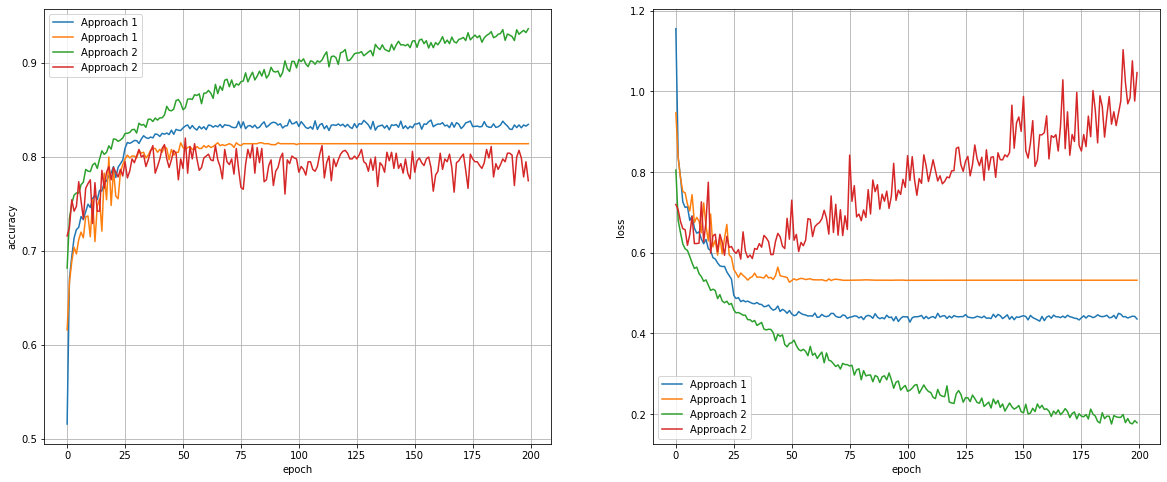

In [168]:
# Combining learning curve to visualize overall performance of transfer learning 
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(fine_tune_hist.epoch, fine_tune_hist.history['accuracy'], label='Approach 1')
plt.plot(fine_tune_hist.epoch, fine_tune_hist.history['val_accuracy'], label='Approach 1')
plt.plot(new_hist.epoch, new_hist.history['accuracy'], label='Approach 2')
plt.plot(new_hist.epoch, new_hist.history['val_accuracy'], label='Approach 2')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(fine_tune_hist.epoch, fine_tune_hist.history['loss'], label='Approach 1')
plt.plot(fine_tune_hist.epoch, fine_tune_hist.history['val_loss'], label='Approach 1')
plt.plot(new_hist.epoch, new_hist.history['loss'], label='Approach 2')
plt.plot(new_hist.epoch, new_hist.history['val_loss'], label='Approach 2')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

After comparing both approaches, we choose Approach 1 form transfer learning because it has less overfitting and its closer to over target performances.

#### Model Evaluation 

In [181]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print('Test loss: {} Test accuracy: {}'.format(test_loss, test_accuracy))

y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, 1)
f1 = f1_score(test_labels, y_pred, average='macro')
print('F1-score:', f1)

31/31 [==============================] - 0s 3ms/step - loss: 0.5062 - accuracy: 0.8099
Test loss: 0.5061511993408203 Test accuracy: 0.8099089860916138
F1-score: 0.7648697590305465


In [172]:
print(classification_report(test_labels,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       167
           1       0.72      0.86      0.78       248
           2       0.90      0.91      0.91       425
           3       0.77      0.53      0.63       149

    accuracy                           0.81       989
   macro avg       0.79      0.76      0.76       989
weighted avg       0.81      0.81      0.81       989



Confusion Matrix 

In [177]:
cm = confusion_matrix(test_labels,y_pred)

In [178]:
# Plot Confusion Matrix (Adapted from sikit learn)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [179]:
cm_plot_labels = [ 'fibroblast','inflammatory','epithelial','others' ]

Confusion matrix, without normalization
[[122  17  22   6]
 [  8 213  13  14]
 [ 15  19 387   4]
 [ 17  46   7  79]]


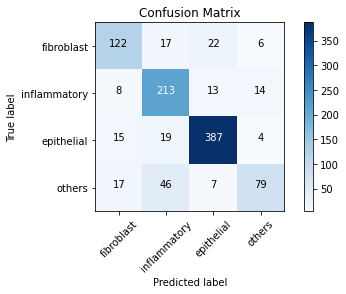

In [180]:
import itertools
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

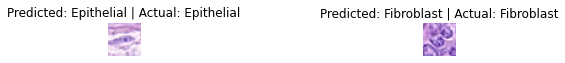

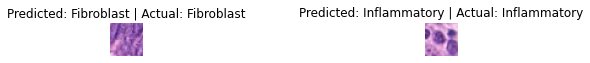

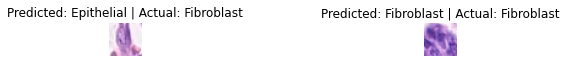

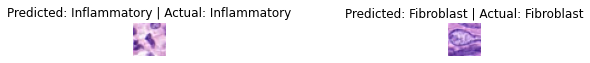

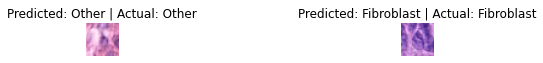

In [184]:
# Examples of the predicted results against the actual data on the test set
label_names = {'Epithelial' : 0, 'Inflammatory' : 1, 'Fibroblast' : 2, 'Other' : 3}

z = 0
while z < 5:
  d_inv = {v: k for k, v in label_names.items()}
  plt.figure(figsize=(16, 0.6))
  batches = 0
  for x, y in test_generator:
          batches = batches + 1
          y_hat = model.predict(x, verbose=0)
          x = np.squeeze(x)
          if batches < 3:
              plt.subplot(1, 3, batches)
              plt.imshow(x)
              plt.title("Predicted: {} | Actual: {}".format(d_inv[np.argmax(y_hat[0])], d_inv[np.argmax(y[0])]))
              
          else:
              break
          
          plt.axis('off')

  z = z + 1

# REFERENCES
1. Chetan L. Srinidhi, Ozan Ciga, & Anne L. Martel, 2020, 'Deep neural network models for computational histopathology: A survey' 
2. Junaid Malik, Serkan Kiranyaz, Suchitra Kunhoth, Turker Ince, Somaya Al-Maadeed, Ridha Hamila, & Moncef Gabbouj, 2019, 'Colorectal cancer diagnosis from histology images: A comparative study'
3. Korsuk Sirinukunwattana, Shan E Ahmed Raza, Yee-Wah Tsang, David R. J. Snead, Ian A. Cree, & Nasir M. Rajpoot, 2016, 'Locality Sensitive Deep Learning for Detection and Classification of Nuclei in Routine Colon Cancer Histology Images' 

